In [1]:
import sparknlp
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np
from helper import *
from metrics import *
from pyspark.ml import PipelineModel
from pyspark.ml.feature import CountVectorizerModel, IDFModel
from pyspark.sql import SparkSession
from sklearn.decomposition import LatentDirichletAllocation
from pyspark.ml.clustering import LocalLDAModel, LDA
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.sql.functions import explode
from sklearn.decomposition import PCA

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lam.nguyen/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lam.nguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lam.nguyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Set up

Initialise SparkSpession

In [2]:
# If run sparknlp, use this
sparknlp_session = sparknlp.start(params={"spark.driver.host": "localhost",
                                          "spark.driver.port": "9999",
                                          "spark.driver.bindAddress": "127.0.0.1",
                                          "spark.driver.maxResultSize": "2g"})

print("Spark NLP version: ", sparknlp.version())
# print("Apache Spark version: ", sparknlp_session.version)
# sparknlp_session.stop()

:: loading settings :: url = jar:file:/Users/lam.nguyen/Desktop/GithubClone/BigData_Final/.venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/lam.nguyen/.ivy2/cache
The jars for the packages stored in: /Users/lam.nguyen/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ed2c7d39-1fde-406b-9bec-ae8dc56594df;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;6.0.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500

Spark NLP version:  6.0.0


Load data

In [3]:
from text_cleaner import clean_text
corpus = pd.read_json(os.path.join("..", "data", "merged", "corpus.json"))
corpus["text"] = corpus["text"].apply(clean_text)
# corpus_ps = sparknlp_session.createDataFrame(corpus)

Train a pyspark Pipeline, TF and IDF model

In [ ]:
# train_pipeline, train_tf, train_idf = pipeline_model(train_data=corpus.copy(deep=True),    
#                                                      spark_session=sparknlp_session)
# train_pipeline.save(os.path.join("..", "model", "at_review", "pipeline"))
# train_tf.save(os.path.join("..", "model", "at_review", "tf"))
# train_idf.save(os.path.join("..", "model", "at_review", "idf"))

25/05/17 10:17:52 WARN StopWordsCleaner: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]

25/05/17 10:18:10 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/05/17 10:18:11 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ / ]Download done! Loading the resource.
[ — ]

[OK!]


25/05/17 10:18:22 WARN TaskSetManager: Stage 2 contains a task of very large size (52494 KiB). The maximum recommended task size is 1000 KiB.
25/05/17 10:29:26 WARN TaskSetManager: Stage 3 contains a task of very large size (52494 KiB). The maximum recommended task size is 1000 KiB.
25/05/17 10:29:29 WARN TaskSetManager: Stage 4 contains a task of very large size (52494 KiB). The maximum recommended task size is 1000 KiB.
25/05/17 10:29:39 WARN TaskSetManager: Stage 8 contains a task of very large size (52494 KiB). The maximum recommended task size is 1000 KiB.


Load trained model

In [4]:
pipeline_path = os.path.join("..", "model", "at_review", "pipeline")
tf_path = os.path.join("..", "model", "at_review", "tf")
idf_path = os.path.join("..", "model", "at_review", "idf")

pipeline = PipelineModel.load(pipeline_path)
tf = CountVectorizerModel.load(tf_path)
idf = IDFModel.load(idf_path)

25/05/19 18:21:04 WARN StopWordsCleaner: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
25/05/19 18:21:08 WARN StopWordsCleaner: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


Extract features

In [ ]:
# # preprocess using nltk
# corpus_nltk, tfidf_nltk = preprocess_nltk(data=corpus.copy(deep=True))

In [5]:
# Extract features (using SparkNLP)
tfidf_ps = preprocess_sparknlp(data=corpus.copy(deep=True), # PySpark DataFrame
                               spark_session=sparknlp_session,
                               tfidf_model=(tf, idf),
                               pipeline_model=pipeline)

In [3]:
# # Extract features (using nltk)
# tfidf_nltk = pd.read_json(os.path.join("..", "data", "processed", "features_nltk.json"))

# Evaluation

## NTLK preprocessing vs SparkNLP preprocessing

In [17]:
# num_rows = [row for row in range(1000, 11000, 1000)]
# num_rows

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

In [7]:
# # Load SparkNLP trained PipelineModel
# pipeline_path = os.path.join("..", "model", "pipeline")
# tf_path = os.path.join("..", "model", "tf")
# idf_path = os.path.join("..", "model", "idf")

# pipeline = PipelineModel.load(pipeline_path)
# tf = CountVectorizerModel.load(tf_path)
# idf = IDFModel.load(idf_path)


25/05/04 12:31:19 WARN StopWordsCleaner: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.
25/05/04 12:31:21 WARN StopWordsCleaner: Default locale set was [en_VN]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


In [10]:
# nltk_time = []
# sparknlp_time = []
# for row in num_rows:
#     subset_df = corpus.copy(deep=True).head(row)
#     # NLTK time
#     nltk_start = time.time()
#     nlkt_result = preprocess_nltk(data=subset_df)
#     nltk_end = time.time()
#     nltk_time.append(nltk_end - nltk_start)

#     # SparkNLP time
#     sparknlp_start = time.time()
#     sparknlp_result = preprocess_sparknlp(data=subset_df,
#                                           spark_session=sparknlp_session,
#                                           tfidf_model=(tf, idf),
#                                           pipeline_model=pipeline)
#     sparknlp_end = time.time()
#     sparknlp_time.append(sparknlp_end - sparknlp_start)

In [14]:
# time_df = pd.read_csv(os.path.join("..", "evaluation_result", "nltk_sparknlp.csv"))
# time_df[['nltk', 'sparknlp']] = time_df[['nltk', 'sparknlp']].astype(int)
# time_df

,nltk,sparknlp
0,63,13
1,115,22
2,174,33
3,230,48
4,296,57
5,347,67
6,408,79
7,456,87
8,510,130
9,642,116


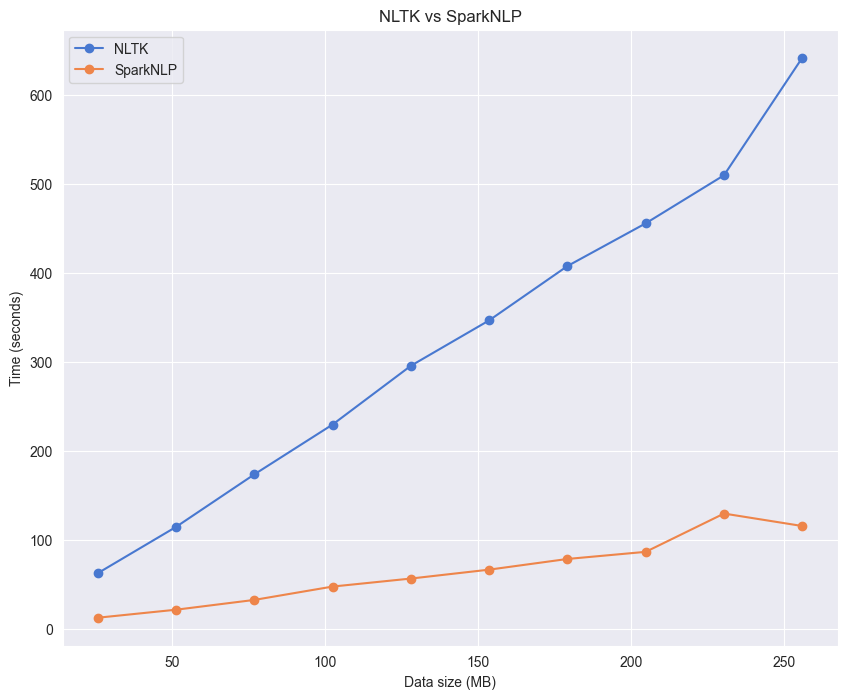

In [54]:
# # Plotting 
# paper_size = 0.02561 # 10000 papers has a total of 256,1MB
# horizontal_axis = [num_papers*paper_size for num_papers in num_rows]
# plt.figure(figsize=(10, 6))
# sns.set_palette(sns.color_palette("muted"))
# sns.set_style('darkgrid')
# plt.plot(horizontal_axis, time_df['nltk'], label='NLTK', marker='o')
# plt.plot(horizontal_axis, time_df['sparknlp'], label='SparkNLP', marker='o')
# plt.xlabel('Data size (MB)')
# plt.ylabel('Time (seconds)')
# plt.title('NLTK vs SparkNLP')
# plt.legend()
# plt.grid(True)
# # plt.savefig(os.path.join("..", "img", 'nltk_sparknlp.png'), format='png', dpi=500)
# plt.show()

## Throughput, time, speedup when use PySpark vs Scikit-learn to train model

In [4]:
# num_rows = [row for row in range(1000, 11000, 1000)]
# num_rows

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

In [5]:
# num_topics = 5
# max_iter = 10

In [ ]:
# subset_df = [pd.read_csv(os.path.join("..", "data", "throughput_cal", str(row) + ".csv"), index_col=0) for row in num_rows]
# subset_ps = []
# for row in num_rows:
#     path = os.path.join("..", "data", "throughput_cal", str(row) + ".csv")
#     tmp_df = pd.read_csv(os.path.join("..", "data", "throughput_cal", str(row) + ".csv"))

#     row_objects = [
#         Row(tf_idf_features=Vectors.dense(vec)) for vec in tmp_df.values
#     ]
#     tfidf = spark.createDataFrame(row_objects)
#     subset_ps.append(tfidf)

In [ ]:
# subset_df = [tfidf_nltk.copy(deep=True).head(row) for row in num_rows]
# subset_ps = []
# for df in subset_df:
#     tmp = [
#         Row(tf_idf_features=Vectors.dense(vec)) for vec in df.values
#     ]
#     tfidf = sparknlp_session.createDataFrame(tmp)
#     subset_ps.append(tfidf)

In [7]:
# import sys
# input_size = [sys.getsizeof(df) for df in subset_df]

[3352016,
 6704016,
 10056016,
 13408016,
 16760016,
 20112016,
 23464016,
 26816016,
 30168016,
 33520016]

In [14]:
# sklearn_time = []
# pyspark_time = []
# for i in range(len(num_rows)):
#     # scikit-learn time
#     sklearn_start = time.time()
#     sklearn_model = LatentDirichletAllocation(n_components=num_topics, 
#                                               max_iter=max_iter)
#     sklearn_model.fit(subset_df[i])
#     sklearn_end = time.time()
#     sklearn_time.append(sklearn_end - sklearn_start)

#     # pyspark time
#     pyspark_start = time.time()
#     pyspark_model = LDA(k=num_topics, 
#                         maxIter=max_iter, 
#                         featuresCol='tf_idf_features')
#     pyspark_model.fit(subset_ps[i])
#     subset_ps[i].unpersist()
#     pyspark_end = time.time()
#     pyspark_time.append(pyspark_end - pyspark_start)

#     print(f"First {num_rows[i]} is complete")
#     print(f"pyspark: {pyspark_end - pyspark_start} - sklearn {sklearn_end - sklearn_start}")


First 1000 is complete
pyspark: 1.4593920707702637 - sklearn 5.064054012298584


25/05/05 08:38:26 WARN TaskSetManager: Stage 242 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:26 WARN TaskSetManager: Stage 243 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:26 WARN TaskSetManager: Stage 244 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:26 WARN TaskSetManager: Stage 245 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:26 WARN TaskSetManager: Stage 246 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:26 WARN TaskSetManager: Stage 247 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:26 WARN TaskSetManager: Stage 248 contains a task of very large size (1856 KiB). The maximum recommended task size is 1000 KiB.

First 2000 is complete
pyspark: 1.7062091827392578 - sklearn 9.010257005691528


25/05/05 08:38:41 WARN TaskSetManager: Stage 264 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:42 WARN TaskSetManager: Stage 265 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:42 WARN TaskSetManager: Stage 266 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:42 WARN TaskSetManager: Stage 267 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:42 WARN TaskSetManager: Stage 268 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:42 WARN TaskSetManager: Stage 269 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:38:42 WARN TaskSetManager: Stage 270 contains a task of very large size (2780 KiB). The maximum recommended task size is 1000 KiB.

First 3000 is complete
pyspark: 1.8465158939361572 - sklearn 14.066035985946655


25/05/05 08:39:02 WARN TaskSetManager: Stage 286 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:02 WARN TaskSetManager: Stage 287 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:02 WARN TaskSetManager: Stage 288 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:02 WARN TaskSetManager: Stage 289 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:02 WARN TaskSetManager: Stage 290 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:03 WARN TaskSetManager: Stage 291 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:03 WARN TaskSetManager: Stage 292 contains a task of very large size (3704 KiB). The maximum recommended task size is 1000 KiB.

First 4000 is complete
pyspark: 2.153738021850586 - sklearn 18.35744571685791


25/05/05 08:39:28 WARN TaskSetManager: Stage 308 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:29 WARN TaskSetManager: Stage 309 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:29 WARN TaskSetManager: Stage 310 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:29 WARN TaskSetManager: Stage 311 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:29 WARN TaskSetManager: Stage 312 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:29 WARN TaskSetManager: Stage 313 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:39:29 WARN TaskSetManager: Stage 314 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.

First 5000 is complete
pyspark: 2.686095952987671 - sklearn 23.97981071472168


25/05/05 08:40:00 WARN TaskSetManager: Stage 330 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:01 WARN TaskSetManager: Stage 331 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:01 WARN TaskSetManager: Stage 332 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:01 WARN TaskSetManager: Stage 333 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:01 WARN TaskSetManager: Stage 334 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:01 WARN TaskSetManager: Stage 335 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:01 WARN TaskSetManager: Stage 336 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.

First 6000 is complete
pyspark: 3.050767183303833 - sklearn 29.715411901474


25/05/05 08:40:35 WARN TaskSetManager: Stage 352 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:36 WARN TaskSetManager: Stage 353 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:36 WARN TaskSetManager: Stage 354 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:36 WARN TaskSetManager: Stage 355 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:36 WARN TaskSetManager: Stage 356 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:36 WARN TaskSetManager: Stage 357 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:40:37 WARN TaskSetManager: Stage 358 contains a task of very large size (3793 KiB). The maximum recommended task size is 1000 KiB.

First 7000 is complete
pyspark: 3.5251970291137695 - sklearn 32.06306195259094


25/05/05 08:41:19 WARN TaskSetManager: Stage 374 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:41:21 WARN TaskSetManager: Stage 375 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:41:21 WARN TaskSetManager: Stage 376 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:41:21 WARN TaskSetManager: Stage 377 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:41:21 WARN TaskSetManager: Stage 378 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:41:22 WARN TaskSetManager: Stage 379 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:41:22 WARN TaskSetManager: Stage 380 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.

First 8000 is complete
pyspark: 6.760176181793213 - sklearn 40.583986043930054


25/05/05 08:42:10 WARN TaskSetManager: Stage 396 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:42:11 WARN TaskSetManager: Stage 397 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:42:11 WARN TaskSetManager: Stage 398 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:42:11 WARN TaskSetManager: Stage 399 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:42:11 WARN TaskSetManager: Stage 400 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:42:11 WARN TaskSetManager: Stage 401 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:42:11 WARN TaskSetManager: Stage 402 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.

First 9000 is complete
pyspark: 2.7346110343933105 - sklearn 43.801127910614014


25/05/05 08:43:07 WARN TaskSetManager: Stage 418 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:43:08 WARN TaskSetManager: Stage 419 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:43:08 WARN TaskSetManager: Stage 420 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:43:08 WARN TaskSetManager: Stage 421 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:43:08 WARN TaskSetManager: Stage 422 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:43:08 WARN TaskSetManager: Stage 423 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.
25/05/05 08:43:09 WARN TaskSetManager: Stage 424 contains a task of very large size (7577 KiB). The maximum recommended task size is 1000 KiB.

First 10000 is complete
pyspark: 3.731799840927124 - sklearn 54.37480092048645


In [15]:
# sample_size = round(sys.getsizeof(tfidf_nltk.iloc[:,0])/(1024**2),2) #size of one sample

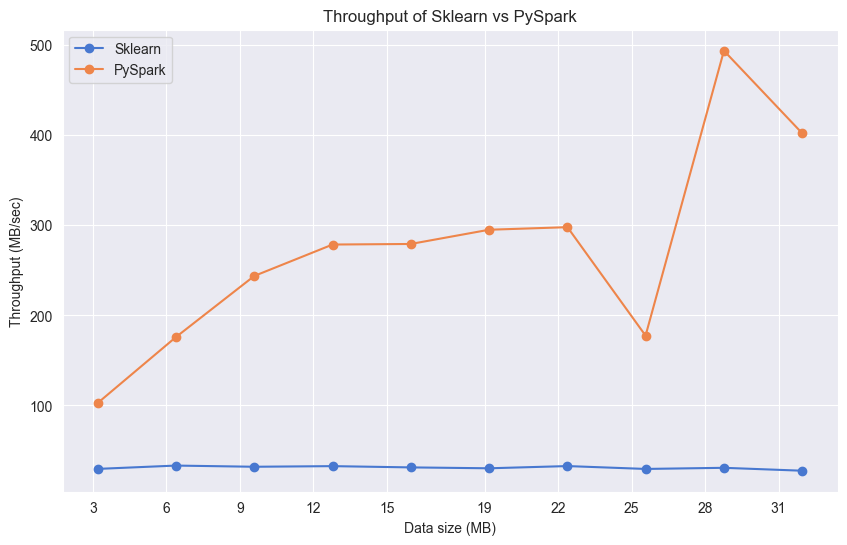

In [17]:
# # Plotting 
# throughput_sklearn = [round(num_rows[i]/sklearn_time[i]*sample_size,2) for i in range(len(num_rows))]
# throughput_pyspark = [round(num_rows[i]/pyspark_time[i]*sample_size,2) for i in range(len(num_rows))]
# horizontal_axis = [round(size/(1024**2),2) for size in input_size]

# plt.figure(figsize=(10, 6))
# sns.set_palette(sns.color_palette("muted"))
# sns.set_style('darkgrid')
# plt.plot(horizontal_axis, throughput_sklearn, label='Sklearn', marker='o')
# plt.plot(horizontal_axis, throughput_pyspark, label='PySpark', marker='o')
# plt.xlabel('Data size (MB)')
# plt.ylabel('Throughput (MB/sec)')
# plt.title('Throughput of Sklearn vs PySpark')
# plt.xticks([int(size) for size in horizontal_axis])
# plt.legend()
# plt.grid(True)
# plt.savefig(os.path.join("..", "img", 'sklearn_pyspark_throughput.png'), format='png', dpi=500)
# plt.show()

In [21]:
# speedup = [throughput_sklearn[i]/throughput_pyspark[i] for i in range(len(throughput_sklearn))]
# speedup

[0.28818836349484334,
 0.1893874765398396,
 0.1312679524004924,
 0.11730500017947522,
 0.11202635914332784,
 0.10267448561065727,
 0.10995098368360974,
 0.16658216438510506,
 0.06243036846476391,
 0.06864037815648713]

/var/folders/ks/tcmmkdsn54j_lc0yv7dzh4sc0000gp/T/ipykernel_3116/203693749.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


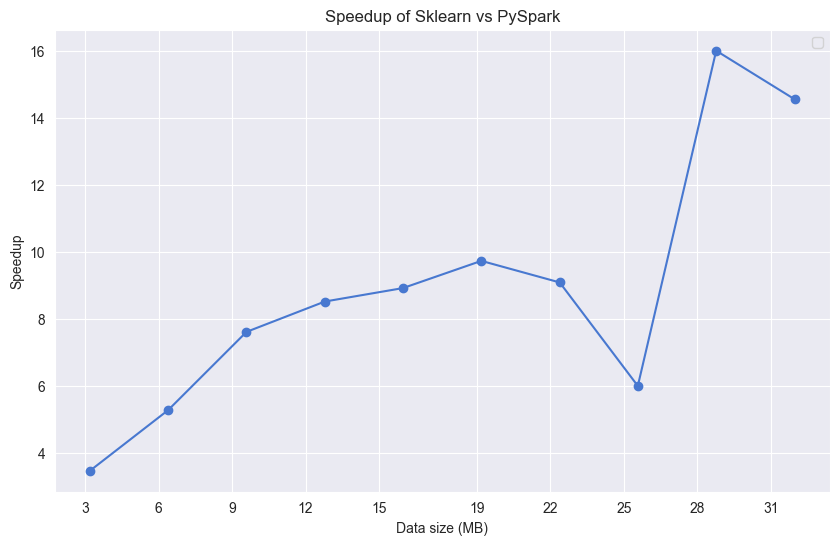

In [23]:
# # Plotting 
# speedup = [throughput_pyspark[i] / throughput_sklearn[i] for i in range(len(throughput_sklearn))]
# horizontal_axis = [round(size/(1024**2),2) for size in input_size]

# plt.figure(figsize=(10, 6))
# sns.set_palette(sns.color_palette("muted"))
# sns.set_style('darkgrid')
# plt.plot(horizontal_axis, speedup, marker='o')
# plt.xlabel('Data size (MB)')
# plt.ylabel('Speedup')
# plt.title('Speedup of Sklearn vs PySpark')
# plt.xticks([int(size) for size in horizontal_axis])
# plt.legend()
# plt.grid(True)
# plt.savefig(os.path.join("..", "img", 'sklearn_pyspark_speedup.png'), format='png', dpi=500)
# plt.show()

## Algorithm performance: PUW calculation

In [ ]:
# max_topics = 20
# num_topics = [k for k in range(2, 5)]
# max_iter = 10
# for k in num_topics:
#     lda_model = LDA(k=k, 
#                     maxIter=max_iter, 
#                     featuresCol='tf_idf_features')
#     lda = lda_model.fit(tfidf_ps)
#     lda.save(os.path.join("..", "model", "at_review", "lda", f"lda{k}"))
#     print(f"Trained LDA with {k} topics successfully")

In [ ]:
# from scipy.spatial.distance import jensenshannon

# def evaluate_topic_diversity(model, df):
#     # Get topic-word distributions
#     topics = model.describeTopics()
#     topic_dists = topics.select("termWeights").rdd.map(lambda x: x[0]).collect()
    
#     # Calculate pairwise Jensen-Shannon distances
#     distances = []
#     for i in range(len(topic_dists)):
#         for j in range(i + 1, len(topic_dists)):
#             dist = jensenshannon(topic_dists[i], topic_dists[j])
#             distances.append(dist)
    
#     # Average distance indicates topic diversity
#     return np.mean(distances)

# def evaluate_lda_comprehensive(df, max_k=20, step=5):
#     results = []
#     k_values = range(2, max_k + 1, step)
    
#     for k in k_values:
#         lda_model = LDA(k=k, maxIter=20, featuresCol='tf_idf_features')
#         model = lda_model.fit(df)
        
#         # Calculate metrics
#         perplexity = np.exp(-model.logLikelihood(df) / model.vocabSize())
#         diversity = evaluate_topic_diversity(model, df)
        
#         results.append((k, perplexity, diversity))
#         print(f"k={k}: Perplexity={perplexity:.2f}, Diversity={diversity:.4f}")
    
#     return results

In [ ]:
# lda = LocalLDAModel.load(os.path.join("..","model", "at_review", "lda10"))

### PUW calculation - Selecting number of topics

In [25]:
num_topics = [k for k in range(2, 21)]
puw_values = []
for k in num_topics:
    puw_topic = 0
    lda = LocalLDAModel.load(os.path.join("..","model", "at_review", "lda", f"lda{k}"))
    puw_res = puw(lda.describeTopics(10),
                  termCol='termIndices')
    for key, value in puw_res.items():
        puw_topic += value
    puw_values.append(round(puw_topic/float(k), 2))
    print(f"Number of topics {k}: {round(puw_topic/float(k), 2)}")

Number of topics 2: 0.9
Number of topics 3: 0.87
Number of topics 4: 0.77
Number of topics 5: 0.58
Number of topics 6: 0.63
Number of topics 7: 0.57
Number of topics 8: 0.65
Number of topics 9: 0.61
Number of topics 10: 0.59
Number of topics 11: 0.53
Number of topics 12: 0.48
Number of topics 13: 0.51
Number of topics 14: 0.52
Number of topics 15: 0.55
Number of topics 16: 0.48
Number of topics 17: 0.49
Number of topics 18: 0.41
Number of topics 19: 0.37
Number of topics 20: 0.35


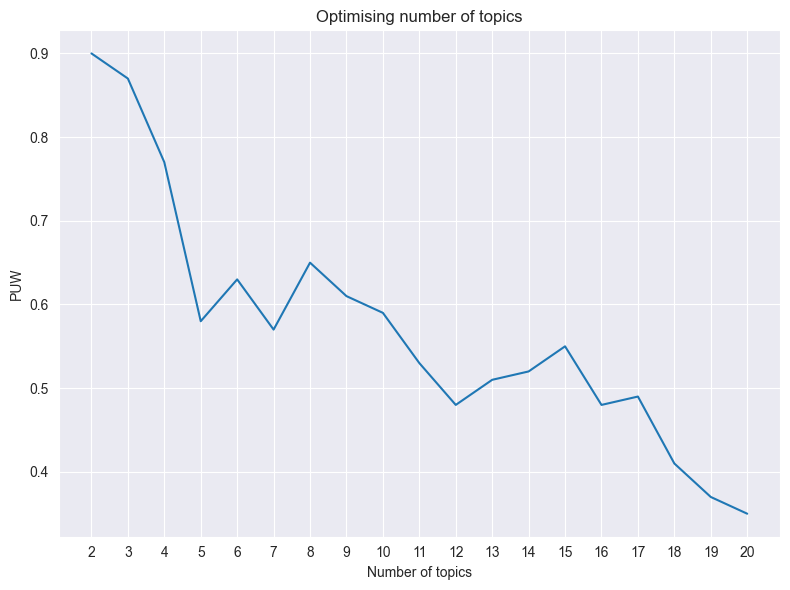

In [ ]:
# Plotting
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
plt.plot(num_topics, puw_values)

plt.title("Optimising number of topics")
plt.xticks(num_topics)
plt.xlabel("Number of topics")
plt.ylabel("PUW")
# plt.savefig(os.path.join("..", "img", 'numTopics.png'), format='png', dpi=500)
plt.tight_layout()
plt.show()


In [6]:
lda_op = LocalLDAModel.load(os.path.join("..","model", "at_review", "lda", "lda2"))

In [7]:
puw(lda_op.describeTopics(10), termCol='termIndices')

{'0': 0.9, '1': 0.9}

### Get top words representing a topic

In [32]:
# Get the vocabulary and mapping of index to word
vocab = tf.vocabulary
index_to_term = {i: vocab[i] for i in range(len(vocab))}

In [33]:
# Get the term indices representing a topic
topic2describe = 11
term_indices = lda_op.describeTopics(topic2describe).select('topic', 'termIndices').collect()

In [34]:
# Get top words representing a topic
topic_words = {term_indices[i]['topic']: term_indices[i]['termIndices'] for i in range(len(term_indices))} # Get term index
for k, v in topic_words.items():
    topic_words[k] = [index_to_term[ind] for ind in v]

In [35]:
pd.DataFrame(topic_words)

,0,1
0,patient,cell
1,covid,protein
2,model,sarscov
3,health,patient
4,social,viral
5,people,virus
6,country,figure
7,care,blood
8,risk,sample
9,symptom,activity


### Plotting topic distribution

In [36]:
ind_firstword = [term_indices[i]['termIndices'][0] for i in range(len(term_indices))]
firstword = [index_to_term[ind] for ind in ind_firstword]

In [37]:
topic2describe = 11
topic_profile = lda_op.describeTopics(topic2describe).select("*").collect()
term_weights = [description['termWeights'] for description in topic_profile]

In [38]:
pca = PCA(n_components=2)
term_weights_2d = pca.fit_transform(term_weights)

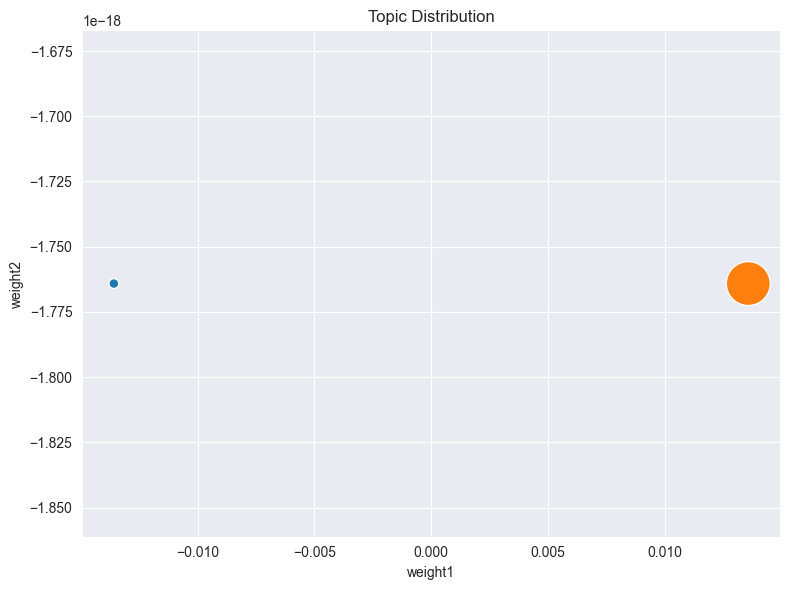

In [39]:
# Create DataFrame and get topic label
df_pca = pd.DataFrame(term_weights_2d, columns=["weight1", "weight2"])
df_pca["Topic_rep"] = firstword

# Set size for bubble
df_pca['size'] = (df_pca['weight1'].abs() + df_pca['weight2'].abs()) * 100  # Adjust size scale

# Plotting
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
sns.scatterplot(data=df_pca, x="weight1", y="weight2", hue="Topic_rep", size='size', sizes=(50, 1000), legend=None)

# Annotate points
for _, row in df_pca.iterrows():
    plt.text(row["weight1"] + 0.0001, row["weight2"] + 0.0001, row["Topic_rep"], fontsize=9)

plt.title("Topic Distribution")
plt.grid(True)
# plt.savefig(os.path.join("..", "img", 'topic_distribution_op14.png'), format='png', dpi=500)
plt.tight_layout()
plt.show()


# BERTopic

In [8]:
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words("english") + ["p", "n", "e", "d", "c", "b", "h", "r", "ie", "eg", "we", "fig"]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lam.nguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from text_cleaner import clean_text
import os
corpus = pd.read_json(os.path.join("..", "data", "merged", "corpus.json"))
corpus["text"] = corpus["text"].apply(clean_text)

In [9]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
pca = PCA(n_components=100)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words=stop_words)

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with
# a `bertopic.representation` model
representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=pca,                           # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model # Step 6 - (Optional) Fine-tune topic representations
)

In [10]:
topics, probs = topic_model.fit_transform(list(corpus['text']))
topic_model.get_topic_info()

RuntimeError: Numpy is not available